In [7]:
import tifffile as tiff
import tensorflow as tf
import pandas as pd
import cv2
import numpy as np

from pathlib import Path
import matplotlib.pyplot as plt

def normalize_image(image: tf.Tensor) -> tf.Tensor:
    """
    Normalize the image so that pixel values are between 0 and 1,
    and it is of dtype tf.float32.
    Args:
        image (tf.Tensor): The image to normalize

    Returns:
        tf.Tensor: The normalized image
    """

    if image.dtype != tf.float32:
        image = tf.cast(image, tf.float32)

    image = tf.transpose(image, perm=[1, 2, 0])

    return image / 65535.0


def find_center_mask(mask: tf.Tensor) -> tf.Tensor:
    """
    Find the centermost mask in the image.
    Args:
        mask (tf.Tensor): mask tensor

    Returns:
        tf.Tensor: new tensor with the centermost mask only
    """

    assert isinstance(mask, tf.Tensor), (
        f"Input must be a tf.Tensor, not {type(mask)}")

    if mask.dtype != bool:
        mask = tf.not_equal(mask, 0.0)

    mask_uint8 = tf.cast(mask, tf.uint8).numpy()

    num_labels, labels, stats, centroids = (
        cv2.connectedComponentsWithStats(mask_uint8))
    mask_center = np.array(mask.shape) // 2

    distances = np.linalg.norm(centroids - mask_center, axis=1)
    closest_label = np.argmin(distances[1:]) + 1
    center_mask = (labels == closest_label).astype('uint8')

    return center_mask


def get_min_max_axis(img: tf.Tensor):
    """
    Finds the extreme points of a binary mask along the x and y axes.
    Args:
        img (tf.Tensor): the binary mask as a torch.Tensor

    Returns:
        tuple: tuple of the minimum and maximum values along the x and y axes
               (ymin, ymax, xmin, xmax)
    """

    assert isinstance(img, tf.Tensor), (
        f"Input must be a tf.Tensor, not {type(img)}")

    nonzero = tf.where(tf.not_equal(img, 0))

    xidx = tf.unique(nonzero[:, 1]).y
    yidx = tf.unique(nonzero[:, 0]).y

    xmin = tf.reduce_min(xidx).numpy()
    ymin = tf.reduce_min(yidx).numpy()

    xmax = tf.reduce_max(xidx).numpy()
    ymax = tf.reduce_max(yidx).numpy()

    return ymin, ymax, xmin, xmax


In [8]:
labels_proc = pd.read_csv('/home/omar/projects/unc/PHASER/data/phaser_rpe/labels.csv')
raw_images = Path('/home/omar/projects/unc/PHASER/data/phaser_rpe/raw/images')

cell_id: cell_0000
True


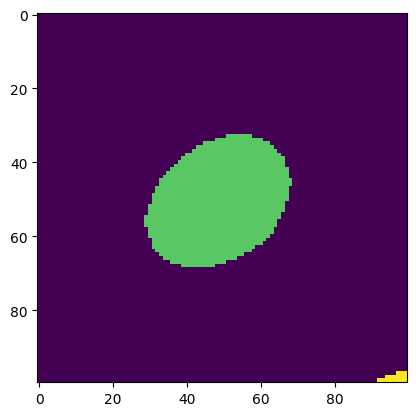

In [77]:
cell_id = labels_proc['cell_id'].iloc[0]
print(f'cell_id: {cell_id}')
masks = []
centered_masks = []

img_path = raw_images / f"{cell_id}.tif"

image = tiff.imread(img_path)
image = normalize_image(image)

nuc_mask = image[:, :, 57]
ring_mask = image[:, :, 58]
combined_mask = tf.maximum(nuc_mask, ring_mask)

unique_values, _ = tf.unique(tf.reshape(combined_mask, [-1]))
print(unique_values.shape[0] > 2)
plt.imshow(combined_mask)

In [80]:
masks = [nuc_mask, ring_mask, combined_mask]
centered_masks = [find_center_mask(mask) for mask in masks]
masks.extend(centered_masks)

masks_to_add = tf.cast(tf.stack(masks[2:], axis=-1), tf.float32)
image = tf.concat([image, masks_to_add], axis=-1)

True


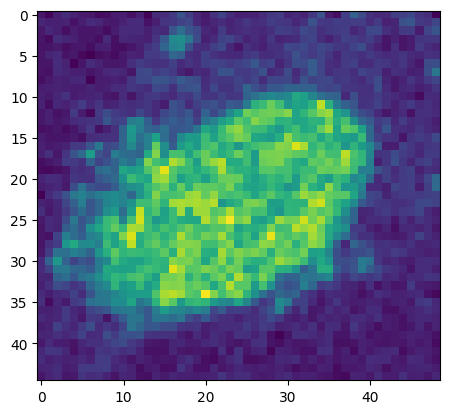

In [82]:
ymin, ymax, xmin, xmax = get_min_max_axis(image[:, :, -1])

offset_height = ymin - 5
offset_width = xmin - 5
target_height = (ymax + 5) - (ymin - 5)
target_width = (xmax + 5) - (xmin - 5)

cropped_image = tf.image.crop_to_bounding_box(
    image, offset_height, offset_width, target_height, target_width)

plt.imshow(cropped_image[:, :, 10])

unique_values, _ = tf.unique(tf.reshape(cropped_image[:, :, -1], [-1]))
print(unique_values.shape[0] == 2)

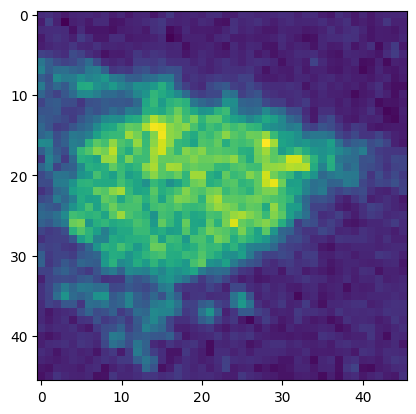

In [88]:
cell_0 = np.load('/home/omar/projects/unc/PHASER/data/phaser_rpe/processed/dynamic_crop/cell_2097.npy')

plt.imshow(cell_0[:, :, 10])